## Importing Required Libraries

In [9]:
import pandas as pd
# from google import drive
# drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Analysis of Labelled and Unlabelled Data

In [10]:
# Unlabelled Data
unlabelled=pd.read_csv('unlabelled_data.csv')

In [11]:
unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


In [12]:
# Labelled Data
labelled=pd.read_csv('labelled_data.csv')
labelled

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"I congratulate you, Sir, on your election as P...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,I am sure we will all benefit from your long e...,AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,Australia enjoys strong bonds of friendship wi...,AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,Australia warmly welcomes to membership of thi...,AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"Equally, as a country of the Asia-Pacific regi...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"As a small country, we care for all those who ...",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"As a digital society, we are a story of hope a...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"Again, as a digital State, we consider transpa...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,We are adamant supporters of rules-based decis...,EST,2017,democracy,0.0


In [13]:
# Removing labelled senteces from unlabelled dataset

mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
final_unlabelled = unlabelled[~mask]
final_unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


### Analysis of labels

1. Distribution of labels


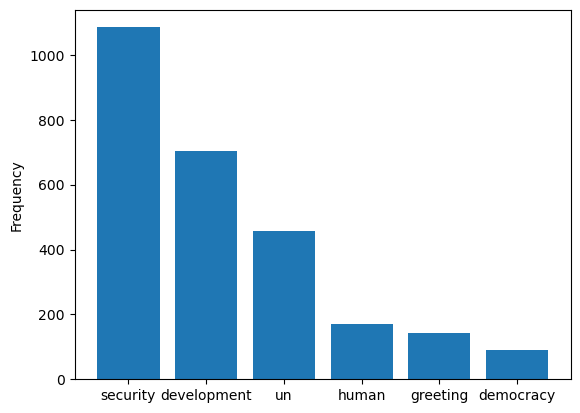

In [14]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

### Preprocessing

1. Remove stopwords (the, a , an...).
2. Remove punctuation (:, , ., ?...).
3. Remove Numbers (1, 199, 12)
4. Remove whitespaces.
5. Converting words into lowercase
6. Tokenization (sentence -> list of words)

In [15]:
def load_sentences(data, type='train'):
  
  '''
    Extracts features and labels from dataset

  '''
  
  sentences, labels = [], []
  sentences = list(data['text'])

  if type == 'train':
    labels = list(data['coding'])
  sentences = [sentence.split('\t') for sentence in sentences]

  return sentences, labels

In [16]:
# Labelled Data
sentences, lables = load_sentences(labelled, 'train')

print('Training Sentences: ',len(sentences))
print('Training Labels: ',len(lables))
print('Training Example: ',sentences[0])

# Unlabelled Data
test_sentences, _ = load_sentences(final_unlabelled, 'test')

print('Testing Sentences: ',len(test_sentences))
print('Testing Example: ',test_sentences[16])

Training Sentences:  2650
Training Labels:  2650
Training Example:  ['I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.']
Testing Sentences:  2039133
Testing Example:  ['The so-called "European concert" is good proof of this concept which restricted the active access of the nonEuropean states to international life.']


### **Functions**

##### Preprocessor class

1. Removes punctuations, numbers, whitespaces
2. Converts sentences into lower case

##### remove_stopword function

1. Removes Stopwords
2. Tokenizes Sentences

##### empty_sentences function

1. Removes the sentences with less than 2 words

In [17]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''
  def __init__(self, numbers=True, punct=True):
    self.numbers = numbers
    self.punct = punct

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)
    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

In [18]:
# Example of preprocessor class
print('Before: ', sentences[0][0])
processor = Preprocessor()
print('After: ', processor.apply(sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  i congratulate you sir on your election as president of the fortysixth session of the general assembly


In [19]:
def remove_stopwords(data):
  '''
    Removes Stopwords
    Tokenizes Sentences
    
  '''
  sentences = []
  split_sent = data.split()
  stopwords_set = set(stopwords.words('english'))
  sentences = [word for word in split_sent if word.lower() not in stopwords_set]
  return sentences

In [20]:
# Example of Removing stopwords and Tokenization
print('Before: ', sentences[0][0])
print('After: ', remove_stopwords(sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  ['congratulate', 'you,', 'Sir,', 'election', 'President', 'forty-sixth', 'session', 'General', 'Assembly.']


In [21]:
processor = Preprocessor()

# Labelled Data
clean_sentences = []
for idx, sentence in tqdm(enumerate(sentences)):
  clean_sentence = processor.apply(sentence[0])
  clean_sentences.append(remove_stopwords(clean_sentence))


# Unlabelled data
# test_clean_sentences = []
# for idx, sentence in tqdm(enumerate(test_sentences)):
#   clean_sentence = processor.apply(sentence[0])
#   test_clean_sentences.append(remove_stopwords(clean_sentence))

2650it [00:00, 8851.65it/s]


In [22]:
print('Example of a cleaned sentence')
print(clean_sentences[0])

Example of a cleaned sentence
['congratulate', 'sir', 'election', 'president', 'fortysixth', 'session', 'general', 'assembly']


In [23]:
# checking for empty sentences
def empty_sentences(data):
  
  '''
    Removes the sentences with less than 2 words
  '''
  print('Length before', len(data))

  sentences = [sublist for sublist in data if not all(elem == "" for elem in sublist)]
  train_sentences = []
  indices = []
  removed_sentences = []
  for idx, sentence in enumerate(sentences):
    if len(sentence) <= 2:
      indices.append(idx)
      removed_sentences.append(sentence)
    else:
      train_sentences.append(sentence)
  print('Length after', len(train_sentences))
  
  return train_sentences, indices, removed_sentences

In [24]:
# Labelled Data
print("Labelled data")
train_sentences, indices, removed_sentences = empty_sentences(clean_sentences)

print()

# Unlabelled data
# print("unlabelled data")
# test_sentences, test_indices, removed_test_sentences = empty_sentences(test_clean_sentences)

Labelled data
Length before 2650
Length after 2604



### **Encoding**

-- BERT

In [25]:
! pip install tensorflow_text

In [26]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text
import numpy as np

2023-04-23 21:42:34.130898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 21:42:34.180082: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 21:42:34.181182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 21:42:34.767966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

2023-04-23 21:42:37.405833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-23 21:42:37.406348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-23 21:42:37.406503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-23 21:42:37.406971: I tensorflow/core/

In [28]:
model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [29]:
def get_embeddings(sentences):
  preproc_text = preprocessor(sentences)
  return model(preproc_text)['pooled_output']


In [30]:
encoded_train = get_embeddings(['More than 4,000 years after their construction, the pyramids still stand as some of the most important and mysterious tombs in the world',
                                'Venu can eat shit',
                                'The Egyptian pyramids are some of the most incredible man-made structures in history.'])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
cosine_similarity([encoded_train[0]], [encoded_train[1]])

array([[0.6433474]], dtype=float32)

In [33]:
cosine_similarity([encoded_train[0]], [encoded_train[2]])

array([[0.99280226]], dtype=float32)

In [34]:
corpus_train_sent = []
for sentence in train_sentences:
  corpus_train_sent.append(" ".join(sentence))

In [35]:
encoded_train = get_embeddings(corpus_train_sent)

In [38]:
encoded_train

<tf.Tensor: shape=(2604, 768), dtype=float32, numpy=
array([[-0.8664386 , -0.405062  , -0.6991607 , ..., -0.51773936,
        -0.56693715,  0.760728  ],
       [-0.80067974, -0.24865906, -0.6266698 , ..., -0.4472373 ,
        -0.43689948,  0.730434  ],
       [-0.7658646 , -0.30170128, -0.40853217, ..., -0.24673072,
        -0.52510834,  0.69515747],
       ...,
       [-0.8801796 , -0.37080878, -0.6042103 , ..., -0.35953856,
        -0.64614713,  0.8084276 ],
       [-0.8886641 , -0.26095387, -0.730861  , ..., -0.30854383,
        -0.50734085,  0.75959975],
       [-0.90591276, -0.46449426, -0.72730905, ..., -0.41756356,
        -0.6898658 ,  0.87320304]], dtype=float32)>

In [45]:
one_string = tf.strings.format("{}", (encoded_train))
print(one_string)

tf.Tensor(b'[[-0.866438627 -0.405062 -0.699160695 ... -0.517739356 -0.566937149 0.760728]\n [-0.800679743 -0.248659059 -0.626669824 ... -0.447237313 -0.436899483 0.730434]\n [-0.765864611 -0.301701277 -0.408532172 ... -0.246730715 -0.525108337 0.695157468]\n ...\n [-0.880179584 -0.37080878 -0.604210317 ... -0.359538555 -0.646147132 0.808427572]\n [-0.888664126 -0.260953873 -0.730861 ... -0.308543831 -0.507340848 0.759599745]\n [-0.905912757 -0.464494258 -0.727309048 ... -0.417563558 -0.689865828 0.873203039]]', shape=(), dtype=string)


In [52]:
strin=''.join([str(i) for i in encoded_train])

In [57]:
print(strin[:2000])

tf.Tensor(
[-8.66438627e-01 -4.05061990e-01 -6.99160695e-01  7.27808416e-01
  3.40399802e-01 -5.78754283e-02  8.53203177e-01  1.87466249e-01
 -5.59290588e-01 -9.99976814e-01 -2.43072107e-01  8.71866226e-01
  9.73141730e-01  4.40849453e-01  8.81304622e-01 -6.09704673e-01
 -3.79022509e-01 -4.34092730e-01  4.20286298e-01 -3.44281793e-01
  6.03318691e-01  9.99877930e-01  2.79861152e-01  2.63501316e-01
  3.65244508e-01  9.57164526e-01 -7.71161199e-01  8.54507208e-01
  9.45556998e-01  6.24496996e-01 -6.94492638e-01  3.12179446e-01
 -9.80762661e-01 -1.40338853e-01 -7.51326561e-01 -9.86367524e-01
  3.68157595e-01 -6.53157532e-01 -3.70124355e-04 -7.44309798e-02
 -8.31001878e-01  3.65614295e-01  9.99889553e-01  3.38804871e-01
  2.15131521e-01 -2.53334016e-01 -9.99999404e-01  1.36075988e-01
 -7.69760370e-01  7.63537824e-01  6.22122347e-01  6.38821363e-01
  1.82172701e-01  4.76627469e-01  4.87664580e-01 -1.17541626e-02
 -1.46065608e-01  7.76287615e-02 -3.22926015e-01 -4.39602137e-01
 -5.30514300e-

In [58]:
tf.io.write_file('encoded_train.txt', strin)

In [59]:
raw = tf.io.read_file('encoded_train.txt')